In [11]:
import random
import numpy as np
import torch
from transformers import BertTokenizerFast, GPT2LMHeadModel

import json
import random
import cv2
import matplotlib.pyplot as plt

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = GPT2LMHeadModel.from_pretrained('ckiplab/gpt2-base-chinese')

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(21128, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

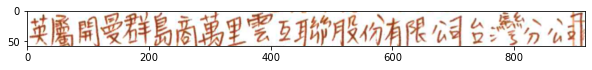

In [14]:
input_img = cv2.imread('截圖 2021-01-15 下午5.53.07.png')

plt.figure(figsize=(10,10))
plt.imshow(input_img)
plt.show()

In [ ]:
with open('test.json', 'r', encoding='utf-8') as f:
    output = json.load(f)
    
blocks = output["responses"][0]["fullTextAnnotation"]["pages"][0]["blocks"]

In [ ]:
def viterbi(cand_seq, cand_seq_prob, e_seq_):
    
    m = torch.nn.Softmax(dim=1)
    
    # emission_token
    e_seq = parse_json_to_character(e_seq_)
    e_token = tokenizer.encode(e_seq)[1:-1]  
    e_token = torch.tensor(e_token).cuda()
    
    ## first iter
    if cand_seq_prob == None:   
        
        cand_seq = parse_json_to_character(cand_seq)
        
        # Encode a first inputs
        cand_seq = tokenizer.encode(cand_seq)[1:-1]
        
        # Convert indexed tokens in a PyTorch tensor
        cand_seq = torch.tensor(cand_seq).cuda()
        
        # init head
        init_str = torch.tensor([101]).repeat(len(cand_seq)).cuda()
        
        # Candidate sequence
        cand_seq = torch.cat((torch.unsqueeze(init_str, 1), torch.unsqueeze(cand_seq, 1)), 1)
        
        # LM model & sigmoid transform
        outputs = model(cand_seq)
        cand_seq_prob = outputs[0][:,-1,:]
        cand_seq_prob = cand_seq_prob[:,e_token]    # shape (20, 20)  #  (candidate dim, emission dim)
        cand_seq_prob = m(cand_seq_prob)
    else: 
        outputs = model(cand_seq)
        cand_seq_prob = outputs[0][:,-1,:]
        cand_seq_prob = cand_seq_prob[:,e_token]    # shape (20, 20)  #  (candidate dim, emission dim)
        cand_seq_prob = m(cand_seq_prob)
    
    
    w = .3
    img_conf = parse_json_to_confidence(e_seq_)
    img_conf = torch.tensor(img_conf).repeat(len(cand_seq)).view(len(cand_seq),len(cand_seq)).cuda()
    cand_seq_prob = w*cand_seq_prob + (1-w)*img_conf
    
    top_e_prob  = torch.max(cand_seq_prob, dim=0)[0]
    top_e_index = torch.max(cand_seq_prob, dim=0)[1].type(torch.long)
    
    next_e = e_token[top_e_index]
    new_cand = torch.cat((cand_seq, torch.unsqueeze(next_e, 1)), 1)
    return new_cand, top_e_prob, cand_seq_prob

def parse_json_to_character(word):
    return "".join(word['symbols'][0]['character'])

def parse_json_to_confidence(word):
    return word['symbols'][0]['confidence']

In [ ]:
cand_seq_prob = None

for block in blocks:    
    words = block["paragraphs"][0]["words"]
    
    for i, word in enumerate(words[:-1]):
        if i == 0:
            best_path, top_e_prob, cand_seq_prob = viterbi(word, cand_seq_prob, words[i+1])
        else:
            best_path, top_e_prob, cand_seq_prob = viterbi(best_path, top_e_prob, words[i+1])

In [ ]:
for c in best_path:
    print (tokenizer.decode(c))

## Best probability

In [ ]:
tokenizer.decode(best_path[torch.argmax(top_e_prob)])